# Selector Group Chat
SelectorGroupChat implements a team where participants take turns broadcasting messages to all other members. A generative model (e.g., an LLM) selects the next speaker based on the shared context, enabling dynamic, context-aware collaboration.

Key features include:
- Model-based speaker selection
- Configurable participant roles and descriptions
- Prevention of consecutive turns by the same speaker (optional)
- Customizable selection prompting
- Customizable selection function to override the default model-based selection

SelectorGroupChat is a group chat similar to RoundRobinGroupChat, but with a model-based next speaker selection mechanism. When the team receives a task through run() or run_stream(), the following steps are executed:
1. The team analyzes the current conversation context, including the conversation history and participants’ name and description attributes, to determine the next speaker using a model. You can override the model by providing a custom selection function.
2. The team prompts the selected speaker agent to provide a response, which is then broadcasted to all other participants.
3. The termination condition is checked to determine if the conversation should end, if not, the process repeats from step 1.
4. When the conversation ends, the team returns the TaskResult containing the conversation history from this task.

Once the team finishes the task, the conversation context is kept within the team and all participants, so the next task can continue from the previous conversation context. You can reset the conversation context by calling reset().

## Load Azure Configurations

In [4]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Create Azure OpenAI Client
Using the model client class

In [17]:
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# Create the token provider
#token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")

az_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment=azure_openai_deployment,
    model=azure_openai_deployment,
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    # azure_ad_token_provider=token_provider,  # Optional if you choose key-based authentication.
    api_key=azure_openai_key, # For key-based authentication.
)

from openai import AzureOpenAI

# Create the Dalle client
dalle_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
dalle_deployment_name = "dall-e-3"

# Create the Vision client
vision_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
vision_deployment_name = "gpt-4o"

## Creating the Agents

In [18]:
from typing import Sequence
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.messages import AgentEvent, ChatMessage
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.agents.web_surfer import MultimodalWebSurfer
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path


# Define a tool
# This function calls the Dalle-3 image generator given the prompt and displays the generated image.
def generate_image(prompt: str) -> str:
    """
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
    """

    print("Dalle Assistant Message: Creating the image ...")

    response = dalle_client.images.generate(
        model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
    )

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "temp.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: " + full_path)
    return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"

# Define an agent
dalle_assistant = AssistantAgent(
    name="dalle_assistant",
    description="This agent calls the Azure OpenAI Dall-e 3 model to generate an image from a text prompt coming from the user or a vision assistant.",
    model_client=az_model_client,
    tools=[generate_image],
    system_message="""
    As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. 
    It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, 
    prior to delivering a response.
    """,
)

In [19]:
# Analyze the image
def analyze_image() -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
    """
    print("Vision Assistant Message: " + "Analyzing the image...")

    import base64
    from pathlib import Path

    # Create a Path object for the image file
    image_path = Path("temp.jpg")

    # Using a context manager to open the file with Path.open()
    with image_path.open("rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    content_images = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
        for base64_image in [base64_image]
    ]
    response = vision_client.chat.completions.create(
        model=vision_deployment_name,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                    },
                    *content_images,
                ],
            }
        ],
        max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

# Define an agent
vision_assistant = AssistantAgent(
    name="Vision_assistant",
    description="This agent analyzes and critic an image and return the result. The resulting output should be a new prompt for dalle assistant that enhances the image based on the criticism and analysis",
    model_client=az_model_client,
    tools=[analyze_image],
    system_message="""
    As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. 
    Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision 
    before you provide feedback to the user. You have access to the local file system where the image is stored.
    """,
)

In [20]:
planning_agent = AssistantAgent(
    "PlanningAgent",
    description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
    model_client=az_model_client,
    system_message=f"""
    You are a planning agent.
    Your job is to break down complex tasks into smaller, manageable subtasks.
    Your team members are:
        Dalle Assistant: An AI specializing in image generation.
        Vision Assistant: An AI expert in image analysis.
        
    You only plan and delegate tasks - you do not execute them yourself.

    When assigning tasks, use this format:
    1. <agent> : <task>
    """,
)

In [21]:
# Create the user proxy agent.
user_proxy = UserProxyAgent("user_proxy", input_func=input)  # Use input() to get user input from console.

## Creating the team
Let’s create the team with two termination conditions: 
- TextMentionTermination to end the conversation when the User Proxy sends “APPROVE”
- MaxMessageTermination to limit the conversation to avoid infinite loop.

In [22]:
text_mention_termination = TextMentionTermination("APPROVE")
max_messages_termination = MaxMessageTermination(max_messages=50)
termination = text_mention_termination | max_messages_termination

team = SelectorGroupChat(
    [planning_agent, dalle_assistant, vision_assistant, user_proxy],
    model_client=az_model_client,
    termination_condition=termination,
)

## Specify the Task and Run the Team

/home/codespace/.python/current/lib/python3.12/site-packages/autogen_ext/models/openai/_openai_client.py:412: DeprecationWarning: capabilities is deprecated, use model_info instead
  if self.capabilities["vision"] is False:
/home/codespace/.python/current/lib/python3.12/site-packages/autogen_ext/models/openai/_openai_client.py:427: DeprecationWarning: capabilities is deprecated, use model_info instead
  if self.capabilities["json_output"] is False and json_output is True:
/home/codespace/.python/current/lib/python3.12/site-packages/autogen_ext/models/openai/_openai_client.py:433: DeprecationWarning: capabilities is deprecated, use model_info instead
  if self.capabilities["function_calling"] is False and len(tools) > 0:


---------- user ----------
Generate an image of a boat drifting in the water and analyze it and enhance the image
---------- PlanningAgent ----------
To accomplish this task, we will need to generate the image and then analyze and enhance it. Here’s the breakdown:

1. Dalle Assistant: Generate an image of a boat drifting in the water.
2. Vision Assistant: Analyze the generated image to identify key details and areas for potential enhancement.
3. Vision Assistant: Enhance the image by improving its visual quality based on the analysis.
[Prompt tokens: 119, Completion tokens: 78]
---------- dalle_assistant ----------
[FunctionCall(id='call_XXXFpIvNQnCGBq8WVPpMslFA', arguments='{"prompt":"a boat drifting in the water, serene environment, gentle waves, realistic and detailed, natural lighting, calm atmosphere"}', name='generate_image')]
[Prompt tokens: 251, Completion tokens: 35]


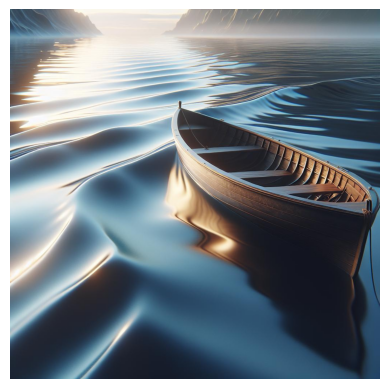

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_XXXFpIvNQnCGBq8WVPpMslFA')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- Vision_assistant ----------
[FunctionCall(id='call_hhE50QvItJ9J4dBtMheyUyRC', arguments='{}', name='analyze_image')]
[Prompt tokens: 278, Completion tokens: 11]
---------- Vision_assistant ----------
[FunctionExecutionResult(content='This image presents a picturesque scene of a small wooden boat floating on a body of water with gentle waves. The setting sun casts a warm glow across the scene, reflecting beautifully off both the water\'s surface and the boat. The surrounding mist and distant cliffs contribute to a serene and tranquil atmosphere. However, there are e

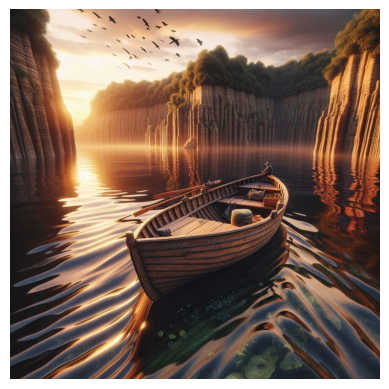

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_fZtrIaYY8ng65hp8xDh4I3sM')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- Vision_assistant ----------
The enhanced image has been successfully generated, incorporating the recommended improvements for realism and storytelling. If you need further adjustments or have other requests, feel free to let me know!
[Prompt tokens: 733, Completion tokens: 35]
---------- user_proxy ----------
I want a boat with a Japanese setting
---------- PlanningAgent ----------
To create an image of a boat in a Japanese setting, we will follow a similar procedure, ensuring that the characteristics and elements typical of a Japanese scene are included. Here’s t

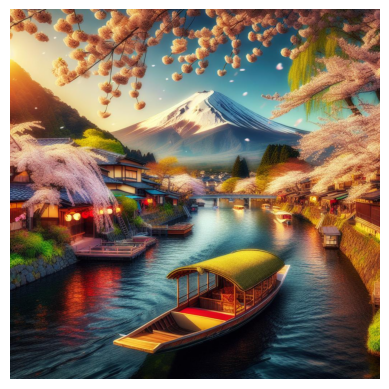

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_fUjUM1haRoInv4zsaQEcwZCJ')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- Vision_assistant ----------
[FunctionCall(id='call_z4r7S4LYMdRAQf1AjLxdT70M', arguments='{}', name='analyze_image')]
[Prompt tokens: 959, Completion tokens: 11]
---------- Vision_assistant ----------
[FunctionExecutionResult(content='This image presents a beautiful and serene Japanese landscape, potentially inspired by the iconic views of Mount Fuji. The setting is lush with cherry blossom trees, adding romantic and cultural charm. The traditional architecture of the houses, combined with the softly flowing waterway and boat, convey tranquility and a vintage ambien

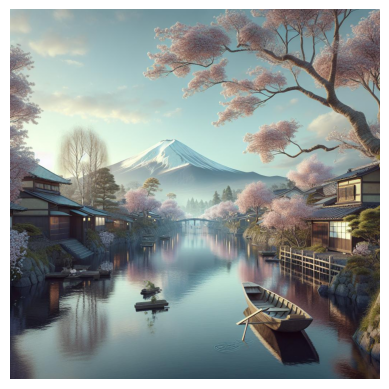

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_tk4t7rUufLUuKVeMylD0g4oL')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- Vision_assistant ----------
The enhanced image, now reflective of a rich, serene Japanese setting with improved depth and realism, has been successfully generated. If you have any more requests or need further modifications, feel free to let me know!
[Prompt tokens: 1397, Completion tokens: 43]
---------- user_proxy ----------
APPROVE
---------- Summary ----------
Number of messages: 27
Finish reason: Text 'APPROVE' mentioned
Total prompt tokens: 9311
Total completion tokens: 646
Duration: 140.80 seconds


In [23]:
task = "Generate an image of a boat drifting in the water and analyze it and enhance the image"
# Use asyncio.run(...) if you are running this in a script.
response = await Console(team.run_stream(task=task))

## Printing whole response per agent source

In [24]:
# ANSI escape code for bold text
bold_start = "\033[1m"
bold_end = "\033[0m"

# ANSI escape code for red text
red_start = "\033[31m"
red_end = "\033[0m"

for messages in response.messages:
    source = messages.source
    print(f"{bold_start}{red_start}{source}{bold_end}{red_end}")
    print(messages.content)

user
Generate an image of a boat drifting in the water and analyze it and enhance the image
PlanningAgent
To accomplish this task, we will need to generate the image and then analyze and enhance it. Here’s the breakdown:

1. Dalle Assistant: Generate an image of a boat drifting in the water.
2. Vision Assistant: Analyze the generated image to identify key details and areas for potential enhancement.
3. Vision Assistant: Enhance the image by improving its visual quality based on the analysis.
dalle_assistant
[FunctionCall(id='call_XXXFpIvNQnCGBq8WVPpMslFA', arguments='{"prompt":"a boat drifting in the water, serene environment, gentle waves, realistic and detailed, natural lighting, calm atmosphere"}', name='generate_image')]
dalle_assistant
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_XXXFpIvNQnCGBq8WVPpMslFA')]
dalle_assistant
Image generated success

## Custom Selector Function
Often times we want better control over the selection process. To this end, we can set the selector_func argument with a custom selector function to override the default model-based selection. For instance, we want the Planning Agent to speak immediately after any specialized agent to check the progress.

---------- user ----------
Generate an image of a boat drifting in the water and analyze it and enhance the image


/home/codespace/.python/current/lib/python3.12/site-packages/autogen_ext/models/openai/_openai_client.py:412: DeprecationWarning: capabilities is deprecated, use model_info instead
  if self.capabilities["vision"] is False:
/home/codespace/.python/current/lib/python3.12/site-packages/autogen_ext/models/openai/_openai_client.py:427: DeprecationWarning: capabilities is deprecated, use model_info instead
  if self.capabilities["json_output"] is False and json_output is True:
/home/codespace/.python/current/lib/python3.12/site-packages/autogen_ext/models/openai/_openai_client.py:433: DeprecationWarning: capabilities is deprecated, use model_info instead
  if self.capabilities["function_calling"] is False and len(tools) > 0:


---------- PlanningAgent ----------
To complete your request, we need to break it down into specific tasks for our team members:

1. Dalle Assistant: Generate an image of a boat drifting in the water.
2. Vision Assistant: Analyze the generated image for any areas of improvement and potential enhancements.
3. Vision Assistant: Enhance the image based on the analysis results.
[Prompt tokens: 119, Completion tokens: 68]
---------- dalle_assistant ----------
[FunctionCall(id='call_0my3MO57TsfRIzCiJ3RTbqSY', arguments='{"prompt":"A boat drifting peacefully on calm water, with a serene sky and subtle reflections on the water surface. The scene is tranquil and picturesque, capturing the essence of relaxation and nature\'s beauty."}', name='generate_image')]
[Prompt tokens: 241, Completion tokens: 50]


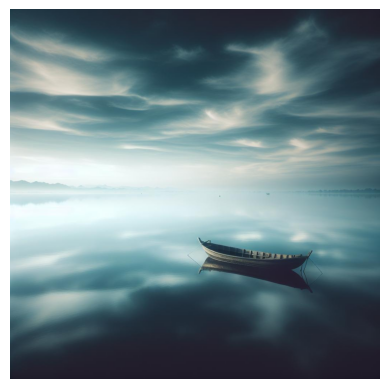

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_0my3MO57TsfRIzCiJ3RTbqSY')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- PlanningAgent ----------
2. Vision Assistant: Analyze the generated image of the boat drifting in the water for any areas of improvement and potential enhancements.
[Prompt tokens: 227, Completion tokens: 25]
---------- Vision_assistant ----------
[FunctionCall(id='call_9RzVjqmctF2DauN5rDyBGMG1', arguments='{}', name='analyze_image')]
[Prompt tokens: 300, Completion tokens: 11]
---------- Vision_assistant ----------
[FunctionExecutionResult(content='This image presents a tranquil and serene scene with a single lone boat on still waters, surrounded by a backdrop of 

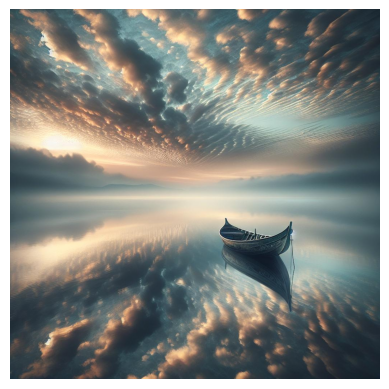

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_A4ISRQklikTXqgOTeD9VV0wz')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- PlanningAgent ----------
The task has been successfully completed, and the image has been generated and enhanced. If you need any other assistance, feel free to ask!
[Prompt tokens: 725, Completion tokens: 28]
---------- user_proxy ----------
APPROVE
---------- Summary ----------
Number of messages: 15
Finish reason: Text 'APPROVE' mentioned
Total prompt tokens: 3048
Total completion tokens: 326
Duration: 68.13 seconds


In [26]:
# This function determines whether the last message in the sequence was sent by the planning_agent. 
# If it wasn't, the function returns the name of the planning_agent; otherwise, it returns None.
# Returning None from the custom selector function will use the default model-based selection.
def selector_func(messages: Sequence[AgentEvent | ChatMessage]) -> str | None:
    if messages[-1].source != planning_agent.name:
        return planning_agent.name
    return None


# Reset the previous team and run the chat again with the selector function.
await team.reset()

team = SelectorGroupChat(
    [planning_agent, dalle_assistant, vision_assistant, user_proxy],
    model_client=az_model_client,
    termination_condition=termination,
    selector_func=selector_func,
)

response = await Console(team.run_stream(task=task))

In [27]:
for messages in response.messages:
    source = messages.source
    print(f"{bold_start}{red_start}{source}{bold_end}{red_end}")
    print(messages.content)

user
Generate an image of a boat drifting in the water and analyze it and enhance the image
PlanningAgent
To complete your request, we need to break it down into specific tasks for our team members:

1. Dalle Assistant: Generate an image of a boat drifting in the water.
2. Vision Assistant: Analyze the generated image for any areas of improvement and potential enhancements.
3. Vision Assistant: Enhance the image based on the analysis results.
dalle_assistant
[FunctionCall(id='call_0my3MO57TsfRIzCiJ3RTbqSY', arguments='{"prompt":"A boat drifting peacefully on calm water, with a serene sky and subtle reflections on the water surface. The scene is tranquil and picturesque, capturing the essence of relaxation and nature\'s beauty."}', name='generate_image')]
dalle_assistant
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_0my3MO57TsfRIzCiJ3RTbqSY')]
dalle_ass